# Using Dmipy to set up the SMT-NODDI Model

The SMT-NODDI model (*Cabeen et al. 2018*) is a multi-step model that separates the estimation of the standard NODDI parameters into a 2-step approach:

1. First, the volume fractions of the NODDI model only are estimated by casting the NODDI model in the spherical mean framework;
2. Second, fixing the volume fractions from the previous step, the orientation and the dispersion of the NODDI are fitted in the standard modeling framework.

In [1]:
from dmipy.signal_models import cylinder_models, gaussian_models
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()
ball = gaussian_models.G1Ball()

As we will be imposing a tortuosity constraint, we cannot just give these models to the MultiCompartmentSphericalMeanModel directly. First we must create a `BundleModel`, which will act like a 2nd level distributed model in which we can impose tortuosity and the other parameter links:

In [2]:
from dmipy.distributions.distribute_models import BundleModel
bundle = BundleModel([stick, zeppelin])
bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp',
    'C1Stick_1_lambda_par','partial_volume_0')
bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)

In [3]:
bundle.parameter_names

['G2Zeppelin_1_mu', 'C1Stick_1_mu', 'partial_volume_0']

We can then go ahead and and create our SMT-NODDI model with the bundle and ball model as input.

In [4]:
from dmipy.core import modeling_framework
smt_noddi_mod = modeling_framework.MultiCompartmentSphericalMeanModel(models=[bundle, ball])
smt_noddi_mod.parameter_names

We highly recommend installing pathos to take advantage of multicore processing.


['G1Ball_1_lambda_iso',
 'BundleModel_1_partial_volume_0',
 'partial_volume_0',
 'partial_volume_1']

In [5]:
# then we fix the isotropic diffusivity
smt_noddi_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

Calling MultiCompartmentSphericalMeanModel instead of MultiCompartmentModel will automatically fit the spherical mean of the model to the spherical mean of the signal, rather than the regular fitting of separate DWIs to the model.

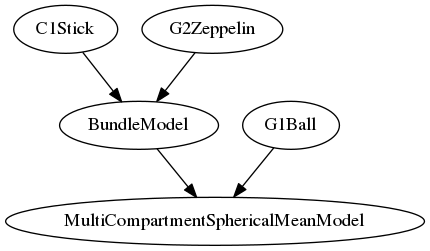

In [6]:
from IPython.display import Image
smt_noddi_mod.visualize_model_setup(view=False, cleanup=False)
Image('Model Setup.png')

## Step 1: Fitting SMT-NODDI to Human Connectome Project data

In [7]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()
sub_image = data_hcp[70:90,: , 70:90]

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


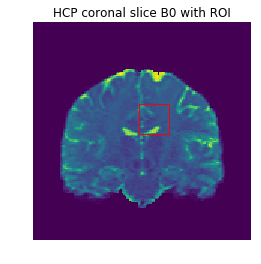

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

In [9]:
# Fitting a spherical mean model is again very fast.
smt_noddi_fit = smt_noddi_mod.fit(scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0, Ns=10)

Setup brute2fine optimizer in 2.67784810066 seconds
Fitting of 8181 voxels complete in 58.916560173 seconds.
Average of 0.00720163307334 seconds per voxel.


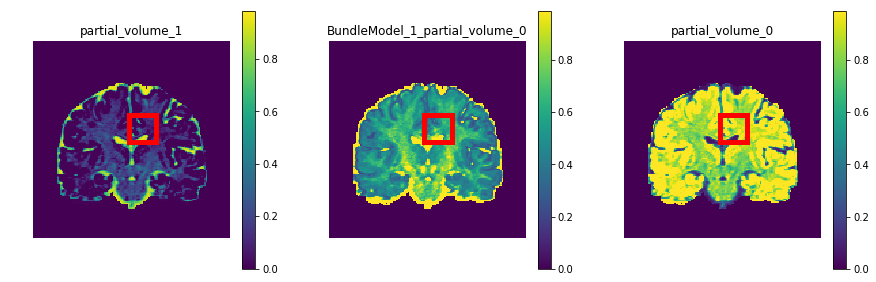

In [10]:
fitted_parameters = smt_noddi_fit.fitted_parameters

fig, axs = plt.subplots(1, len(fitted_parameters), figsize=[15, 5])
axs = axs.ravel()

for i, (name, values) in enumerate(fitted_parameters.items()):
    cf = axs[i].imshow(values.squeeze().T, origin=True)
    axs[i].set_title(name)
    rect = patches.Rectangle((70,70),20,20,linewidth=5,edgecolor='r',facecolor='none')
    axs[i].add_patch(rect)
    axs[i].set_axis_off()
    fig.colorbar(cf, ax=axs[i], shrink=.95)

## Step 2: Estimating Watson-FODs while fixing SMT-NODDI volume fractions

Generate the same model as before but now with watson distributed bundle as in standard NODDI

We highly recommend installing pathos to take advantage of multicore processing.


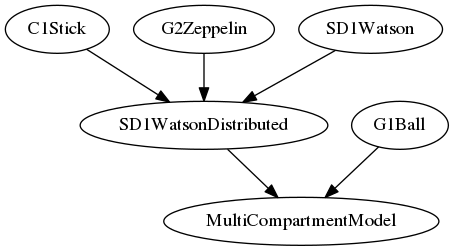

In [14]:
from dmipy.distributions.distribute_models import SD1WatsonDistributed
watson_bundle = SD1WatsonDistributed([stick, zeppelin])
watson_bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp',
    'C1Stick_1_lambda_par','partial_volume_0')
watson_bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
watson_bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)

noddi_mod = modeling_framework.MultiCompartmentModel(
    models=[watson_bundle, ball])
noddi_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)


from IPython.display import Image
noddi_mod.visualize_model_setup(view=False, cleanup=False)
Image('Model Setup.png')

In [15]:
noddi_mod.parameter_names

['SD1WatsonDistributed_1_SD1Watson_1_mu',
 'SD1WatsonDistributed_1_partial_volume_0',
 'SD1WatsonDistributed_1_SD1Watson_1_odi',
 'partial_volume_0',
 'partial_volume_1']

As the model composition is not exactly the same, as we replaced the bundle model with the watson-dispersed model, we have to be careful to fix the right SMT-NODDI parameter with the new NODDI model parameter.

In [16]:
smt_noddi_fit.fitted_parameters.keys()

['partial_volume_1', 'BundleModel_1_partial_volume_0', 'partial_volume_0']

Set the parameters

In [17]:
noddi_mod.set_fixed_parameter(
    'SD1WatsonDistributed_1_partial_volume_0',
    smt_noddi_fit.fitted_parameters['BundleModel_1_partial_volume_0'])
noddi_mod.set_fixed_parameter(
    'partial_volume_0', smt_noddi_fit.fitted_parameters['partial_volume_0'])
noddi_mod.set_fixed_parameter(
    'partial_volume_1', smt_noddi_fit.fitted_parameters['partial_volume_1'])

We then fit the same data again but with the new cascaded model.

In [18]:
noddi_fit_2step = noddi_mod.fit(scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)

Cannot estimate signal grid with voxel-dependent x0_vector.
Setup brute2fine optimizer in 0.00014591217041 seconds
Fitting of 8181 voxels complete in 2469.64168811 seconds.
Average of 0.301875282742 seconds per voxel.


The optimization actually takes longer than the standard NODDI model because the brute force signal grid cannot be pre-calculated on a regular grid (each voxel has a different starting position in terms of volume fractions).

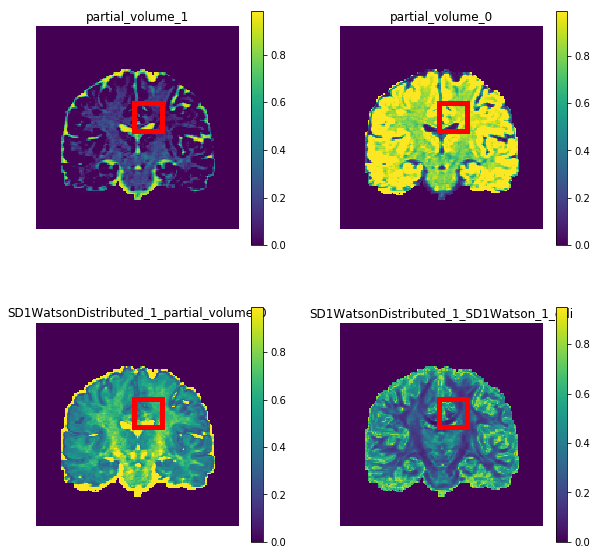

In [35]:
fitted_parameters = noddi_fit_2step.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

i = 0
for name, values in fitted_parameters.items():
    if noddi_mod.parameter_cardinality[name] > 1:
        continue
    cf = axs[i].imshow(values.squeeze().T, origin=True)
    axs[i].set_title(name)
    rect = patches.Rectangle((70,70),20,20,linewidth=5,edgecolor='r',facecolor='none')
    axs[i].add_patch(rect)
    axs[i].set_axis_off()
    fig.colorbar(cf, ax=axs[i], shrink=.95)
    i += 1

Note here that all the volume fraction parameter maps are identical to the SMT-NODDI step as they were fixed during optimization.

### Spherical Harmonics FOD visualization

In [21]:
from dipy.data import get_sphere
from dipy.viz import window, actor
sphere = get_sphere(name='symmetric724').subdivide()
fods = noddi_fit_2step.fod(sphere.vertices)[70:90,: , 70:90]

In [22]:
import numpy as np
affine = np.eye(4)
vf_intra = (
    noddi_fit_2step.fitted_parameters['SD1WatsonDistributed_1_partial_volume_0'][70:90,: , 70:90] *
    noddi_fit_2step.fitted_parameters['partial_volume_0'][70:90,: , 70:90])
volume_im = actor.slicer(vf_intra[:, 0, :, None], interpolation='nearest', affine=affine, opacity=0.7)

In [23]:
ren = window.Renderer()
fod_spheres = actor.odf_slicer(
    fods, sphere=sphere, scale=0.9, norm=False)
fod_spheres.display_extent(0, fods.shape[0]-1, 0, fods.shape[1]-1, 0, fods.shape[2]-1)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
ren.add(fod_spheres)
ren.add(volume_im)
window.record(ren, size=[700, 700])

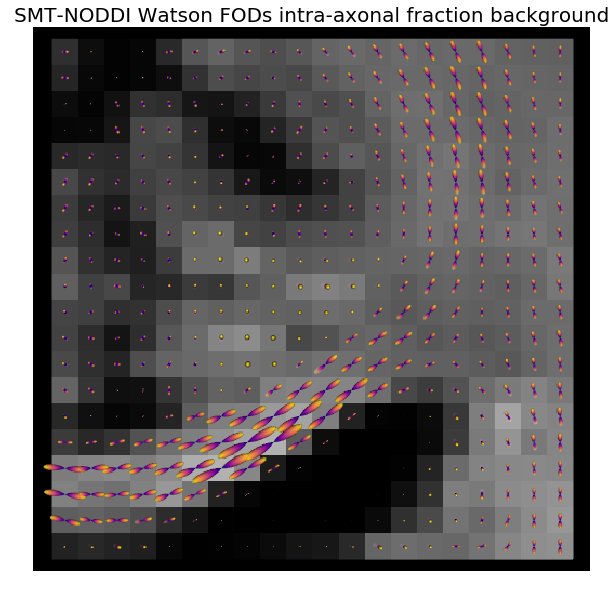

In [24]:
import matplotlib.image as mpimg
img = mpimg.imread('fury.png')

plt.figure(figsize=[10, 10])
plt.imshow(img[100:-97, 100:-85])
plt.title('SMT-NODDI Watson FODs intra-axonal fraction background', fontsize=20)
plt.axis('off');

The final FODs are very similar as those in the standard NODDI example. It remains to be studied if this 2-step cascaded implementation has more clinically relevant measures than the single-shot "standard" NODDI model.

#### References
1. Rapid and Accurate NODDI Parameter Estimation with the Spherical Mean Technique, Ryan P Cabeen , Farshid Sepehrband , and Arthur W Toga, 2018.